# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1  Device: cpu


## 3. CIFAR10 데이터 다운로드 (Train data와 Test data 분리하기)

In [3]:
BATCH_SIZE = 32 

train_data = datasets.CIFAR10 ('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10 ('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader (dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader (dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## 4. 첫번째 batch 데이터의 크기와 타입을 확인하기

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [5]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(3*32*32, 100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x 

## 5. 초기화를 위한 함수 만들기

In [6]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data,0)
        nn.init.constant_(m.bias.data, 0)

def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data)
        nn.init.normal_(m.bias.data)  

def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        #nn.init.xavier_normal_(m.bias.data,0)

def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)
        #nn.init.kaiming_normal_(m.bias.data,0)

## 6. 모델 객체 만들고 다르게 초기화 하기

In [7]:
########## 아래 채우시오에 함수명을 적으면됩니다.
network_const = Model()
network_const.apply(init_constants)

network_normal = Model()
network_normal.apply(init_normal)

network_xaiver = Model()
network_xaiver.apply(init_xavier)

network_kaiming = Model()
network_kaiming.apply(init_kaiming)

Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [8]:
    def training_epoch(train_loader, network, loss_func, optimizer, epoch):
        train_losses = []
        train_correct = 0
        log_interval = 500

        for batch_idx, (image, label) in enumerate(train_loader):
            # 미분값의 초기화
            optimizer.zero_grad()

            # 이미지를 (batch_size, 3072) 차원의 메트릭스로 만드세요
            batch_size = image.size()[0]
            image = image.view(batch_size, 3072)

            # Forward propagration 계산하기.
            outputs = network(image)

            # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
            loss = loss_func(outputs,label)
            train_losses.append(loss.item())

            # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
            pred = outputs.data.max(dim=1)[1]
            train_correct += pred.eq(label).sum()

            # Gradinet 구하기
            loss.backward()

            # weight값 update 하기
            optimizer.step()

            # 학습 상황 출력
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                      .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                              loss.item()))

        return train_losses, train_correct

In [9]:
    def test_epoch(test_loader, network, loss_func):
        correct = 0

        test_losses = []

        with torch.no_grad():
            for batch_idx, (image, label) in enumerate(test_loader):
                batch_size = image.size()[0]
                image = image.view(batch_size,3072)

                # Forward propagration 계산하기.
                outputs = network(image)

                # Cross_entropy 함수를 적용하여 loss를 구하기
                loss = loss_func(outputs,label)
                test_losses.append(loss.item())

                # Batch 별로 정확도 구하기
                pred = outputs.data.max(1)[1]
                correct += pred.eq(label).sum()

            # 전체 정확도 구하기
            test_accuracy = 100. * correct / len(test_loader.dataset)

            #중간결과 출력
            print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
                  .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
        return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

In [10]:
    def training(network):

        learning_rate = 0.01
        epoches = 20

        cls_loss = nn.CrossEntropyLoss()
        optimizer = optim.SGD(network.parameters(), lr=learning_rate)

        train_losses_per_epoch = []
        test_losses_per_epoch = []

        train_accuracies = []
        test_accuracies = []


        for epoch in range(epoches):

            # 모델를 학습 중이라고 선언하기
            network.train()

            train_losses, train_correct = training_epoch(train_loader, network, cls_loss, optimizer, epoch)

            # epoch 별로 loss 평균값, 정확도 구하기
            average_loss = np.mean(train_losses)
            train_losses_per_epoch.append(average_loss)

            train_accuracy = train_correct / len(train_loader.dataset) * 100
            train_accuracies.append(train_accuracy)

            # epoch 별로 정확도 출력
            print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
                  .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))


            ### 학습 중에 test 결과 보기

            # 모델 test 중인 것을 선언하기
            network.eval()

            correct = 0
            with torch.no_grad():
                test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

            test_losses_per_epoch.append(np.mean(test_losses))
            test_accuracies.append(test_accuracy)

        return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [11]:
rlt_const = training(network_const)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302585
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.301526
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.303564
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.301433

Training set: Accuracy: 4844/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303619
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.301910
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.303573
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.301404

Training set: Accuracy: 4730/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303838
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.301992
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.301399

Training set: Accuracy: 4738/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303884
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.302010
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 3 [48000/50000 (96%

In [12]:
rlt_normal = training(network_normal)

Train Epoch: 0 [0/50000 (0%)]	Loss: 340.067139
Train Epoch: 0 [16000/50000 (32%)]	Loss: 5.644900
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.493108
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.232935

Training set: Accuracy: 8230/50000 (16%)
Test set: Accuracy: 1465/10000 (15%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.465975
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.751461
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.313449
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.193993

Training set: Accuracy: 8701/50000 (17%)
Test set: Accuracy: 1613/10000 (16%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.190254
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.409408
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.297541
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.172646

Training set: Accuracy: 9152/50000 (18%)
Test set: Accuracy: 1796/10000 (18%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.149024
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.264761
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.253424
Train Epoch: 3 [48000/50000 

In [13]:
rlt_xaiver = training(network_xaiver)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.360765
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.832770
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.830086
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.146314

Training set: Accuracy: 16202/50000 (32%)
Test set: Accuracy: 3624/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.739615
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.671704
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.705651
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.123904

Training set: Accuracy: 19734/50000 (39%)
Test set: Accuracy: 4093/10000 (41%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.618055
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.574932
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.664797
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.097250

Training set: Accuracy: 21045/50000 (42%)
Test set: Accuracy: 4229/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.584353
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.511132
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.624703
Train Epoch: 3 [48000/50000

In [14]:
rlt_kaiming = training(network_kaiming)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.467625
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.867339
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.865850
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.197540

Training set: Accuracy: 15956/50000 (32%)
Test set: Accuracy: 3527/10000 (35%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.841719
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.627911
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.749872
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.116894

Training set: Accuracy: 19375/50000 (39%)
Test set: Accuracy: 3865/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.786491
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.553123
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.709950
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.072262

Training set: Accuracy: 20724/50000 (41%)
Test set: Accuracy: 4006/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.776590
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.493029
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.641426
Train Epoch: 3 [48000/50000

# 학습 결과 보기 
## 1. loss 값 비교

In [15]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

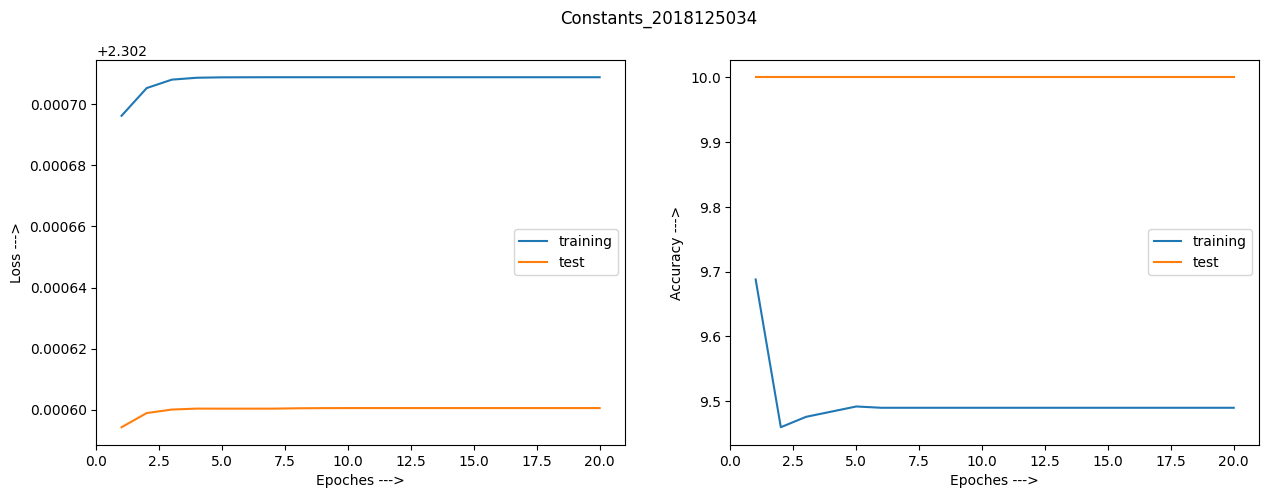

In [16]:
show_rlt(rlt_const, 'Constants_2018125034')

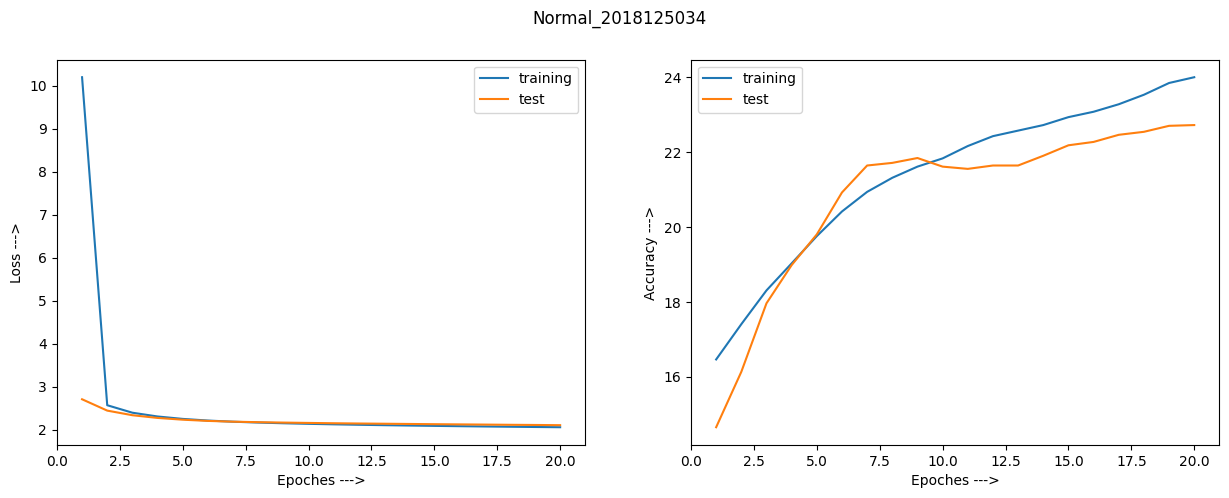

In [17]:
show_rlt(rlt_normal, 'Normal_2018125034')

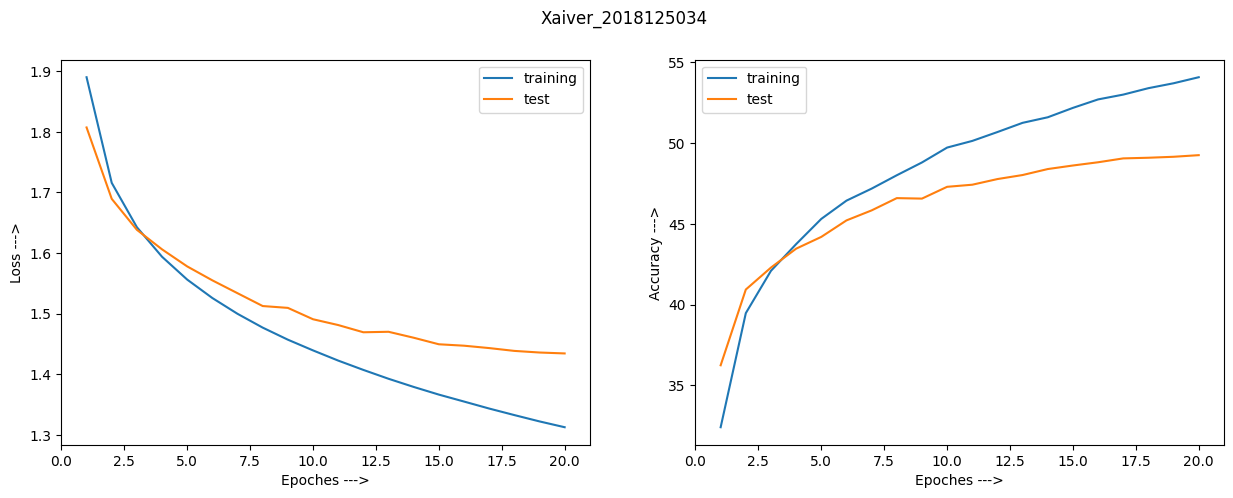

In [18]:
show_rlt(rlt_xaiver, 'Xaiver_2018125034')

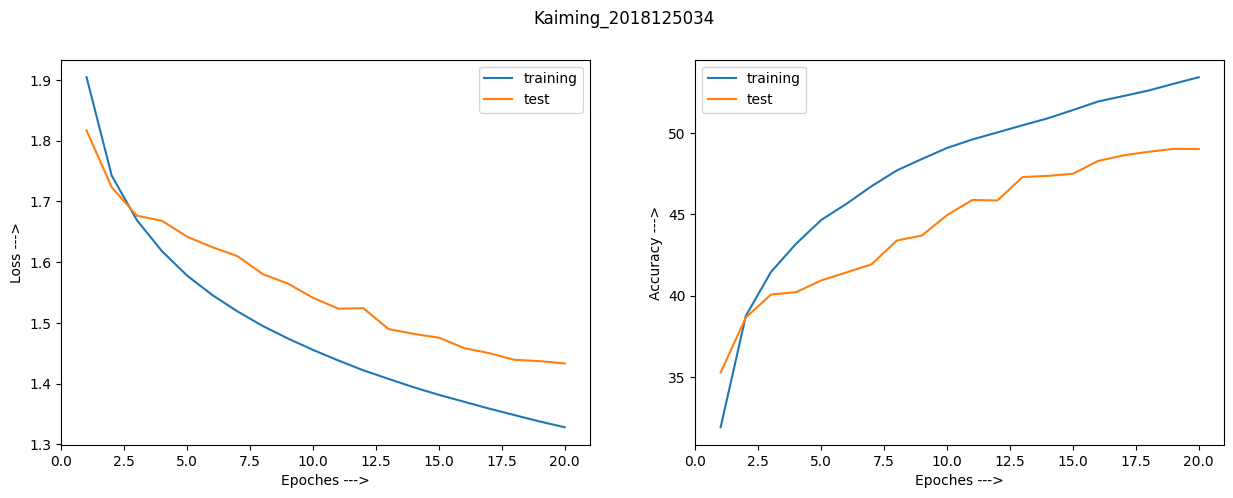

In [19]:
show_rlt(rlt_kaiming, 'Kaiming_2018125034')

## 2. 위 4개의 초기화 방법를 비교하고 성능에 대해서 분석하시오

정답) 첫번째 방법은 가중치와 바이어스를 상수로 초기화 하는 것이다. 하지만 이 과제에서는 0으로 초기화했기 때문에, 가중치가 업데이트 되지 않으며 학습이 전혀 이루어지지 않았음을 확인할 수 있다. 당연히 성능도 무의미하다 <br>
두번째 방법은 normal distribution을 이용한 초기화 방법이다. 이 방법은 표준 편차에 따라 값이 0과 1로 몰리거나, 중앙으로만 몰릴 수 있다. 이 과제에서는 좋은 초기화 방법이라고 볼 수 없다 <br>
세번쨰 방법은 xavier 방법을 이용한 초기화이다. 배치에 들어오는 유닛의 수에 맞춰서 표준 편차값을 결정한다. 나름 균일한 분포를 가지지만, layer가 깊어질 수록 한쪽으로 몰릴 수 있다. 이 과제에서는 렐루 활성화 함수를 사용하는데, 렐루 함수의 특성 상 음수는 0으로 치환하기 때문이다.<br>
네번째 방법은 kaiming 방법인데, 수업 시간에 다룬 He 방법이다. xavier 방법에서 분포를 조금 더 고르게 하기 위해 상수를 곱해주었다. epoch 횟수가 부족해서인지 모르겠지만, 그래프 상에서는 xavier 방법과 큰 두드러진 차이를 확인할 수 없어 아쉽다.<br>
항상 확실한 방법은 없으므로 epoch 수가 늘어난다던지, 모델이 바뀔 때 마다 제일 적절한 방법을 적용하면 될 것 같다